# Setup
You need to run this the first time

In [ ]:
# install requirements
!pip install -r requirements.txt

# install glide
%cd "glide-text2im"
!pip install -e .
%cd ..

# install glide
%cd "rembg"
!pip install -e .
%cd ..

# install Real-ESRGAN
%cd Real-ESRGAN
# Set up the environment
!pip install basicsr
!pip install facexlib
!pip install gfpgan
!pip install -r requirements.txt
!python setup.py develop
# Download the pre-trained model
!wget https://github.com/xinntao/Real-ESRGAN/releases/download/v0.1.0/RealESRGAN_x4plus.pth -P experiments/pretrained_models
%cd ..

# Load Models

In [1]:
from typing import Tuple
from pathlib import Path
import os
from IPython.display import display
from PIL import Image
import numpy as np
import torch as th
import torch.nn.functional as F

from glide_text2im.download import load_checkpoint
from glide_text2im.model_creation import (
    create_model_and_diffusion,
    model_and_diffusion_defaults,
    model_and_diffusion_defaults_upsampler
)

# the upscaler
from upscaler import Upscaler
upscaler = Upscaler()

# This notebook supports both CPU and GPU.
# On CPU, generating one sample may take on the order of 20 minutes.
# On a GPU, it should be under a minute.
has_cuda = th.cuda.is_available()
device = th.device('cpu' if not has_cuda else 'cuda')

# create folders
input_folder = "input_images"
output_folder = "output_images"

Path(f'{input_folder}').mkdir(parents=True, exist_ok=True) 
Path(f'{output_folder}').mkdir(parents=True, exist_ok=True) 

In [41]:
# Create base model.
options = model_and_diffusion_defaults()
options['inpaint'] = True
options['use_fp16'] = has_cuda
options['timestep_respacing'] = '100' # use 100 diffusion steps for fast sampling
model, diffusion = create_model_and_diffusion(**options)
model.eval()
if has_cuda:
    model.convert_to_fp16()
model.to(device)
model.load_state_dict(load_checkpoint('base-inpaint', device))
print('total base parameters', sum(x.numel() for x in model.parameters()))

total base parameters 385037638


In [5]:
# Create upsampler model.
options_up = model_and_diffusion_defaults_upsampler()
options_up['inpaint'] = True
options_up['use_fp16'] = has_cuda
options_up['timestep_respacing'] = 'fast27' # use 27 diffusion steps for very fast sampling
model_up, diffusion_up = create_model_and_diffusion(**options_up)
model_up.eval()
if has_cuda:
    model_up.convert_to_fp16()
model_up.to(device)
model_up.load_state_dict(load_checkpoint('upsample-inpaint', device))
print('total upsampler parameters', sum(x.numel() for x in model_up.parameters()))

total upsampler parameters 398368198


In [6]:
# helper functions
def show_images(batch: th.Tensor):
    """ Display a batch of images inline. """
    scaled = ((batch + 1)*127.5).round().clamp(0,255).to(th.uint8).cpu()
    reshaped = scaled.permute(2, 0, 3, 1).reshape([batch.shape[2], -1, 3])
    display(Image.fromarray(reshaped.numpy()))

def save_image(batch: th.Tensor, path: str):
    scaled = ((batch + 1)*127.5).round().clamp(0,255).to(th.uint8).cpu()
    reshaped = scaled.permute(2, 0, 3, 1).reshape([batch.shape[2], -1, 3])
    img = Image.fromarray(reshaped.numpy())
    img.save(path)

def read_image(path: str, size: int = 256) -> Tuple[th.Tensor, th.Tensor]:
    pil_img = Image.open(path).convert('RGB')
    pil_img = pil_img.resize((size, size), resample=Image.Resampling.BICUBIC)
    img = np.array(pil_img)
    return th.from_numpy(img)[None].permute(0, 3, 1, 2).float() / 127.5 - 1

torch.Size([1, 3, 64, 64])


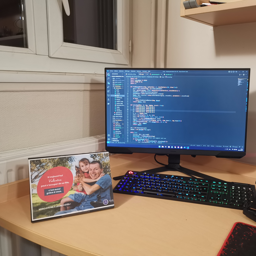

In [42]:
# image path
image_path = "my_room.jpg"

# Sampling parameters
batch_size = 1
# Tune this parameter to control the sharpness of 256x256 images.
# A value of 1.0 is sharper, but sometimes results in grainy artifacts.
upsample_temp = 0.997

# Source image we are inpainting
source_image_256 = read_image(f'{input_folder}/{image_path}', size=256)
source_image_64 = read_image(f'{input_folder}/{image_path}', size=64)

# The mask should always be a boolean 64x64 mask, and then we
# can upsample it for the second stage.
source_mask_64 = th.ones_like(source_image_64)[:, :1]
print(source_image_64.shape)
show_images(source_image_256)

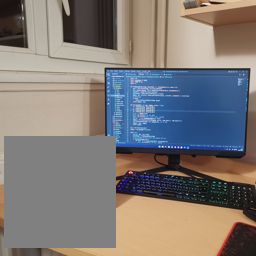

In [43]:
# position and size of the mask
posX, posY = 15, 48
size = 28

x1, x2 = int(posX-(size/2)), int(posX+(size/2))
y1, y2 = int(posY-(size/2)), int(posY+(size/2))
source_mask_64 = th.ones_like(source_image_64)[:, :1]
source_mask_64[:, :, y1:y2, x1:x2] = 0
source_mask_256 = F.interpolate(source_mask_64, (256, 256), mode='nearest')
# Visualize the image we are inpainting
show_images(source_image_256 * source_mask_256)

  0%|          | 0/100 [00:00<?, ?it/s]

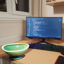

In [56]:
# text prompt parameters
prompt = "an old antique chinese vase. realistic, very detailed vase"
guidance_scale = 30.0

##############################
# Sample from the base model #
##############################

# Create the text tokens to feed to the model.
tokens = model.tokenizer.encode(prompt)
tokens, mask = model.tokenizer.padded_tokens_and_mask(
    tokens, options['text_ctx']
)

# Create the classifier-free guidance tokens (empty)
full_batch_size = batch_size * 2
uncond_tokens, uncond_mask = model.tokenizer.padded_tokens_and_mask(
    [], options['text_ctx']
)

# Pack the tokens together into model kwargs.
model_kwargs = dict(
    tokens=th.tensor(
        [tokens] * batch_size + [uncond_tokens] * batch_size, device=device
    ),
    mask=th.tensor(
        [mask] * batch_size + [uncond_mask] * batch_size,
        dtype=th.bool,
        device=device,
    ),

    # Masked inpainting image
    inpaint_image=(source_image_64 * source_mask_64).repeat(full_batch_size, 1, 1, 1).to(device),
    inpaint_mask=source_mask_64.repeat(full_batch_size, 1, 1, 1).to(device),
)

# Create an classifier-free guidance sampling function
def model_fn(x_t, ts, **kwargs):
    half = x_t[: len(x_t) // 2]
    combined = th.cat([half, half], dim=0)
    model_out = model(combined, ts, **kwargs)
    eps, rest = model_out[:, :3], model_out[:, 3:]
    cond_eps, uncond_eps = th.split(eps, len(eps) // 2, dim=0)
    half_eps = uncond_eps + guidance_scale * (cond_eps - uncond_eps)
    eps = th.cat([half_eps, half_eps], dim=0)
    return th.cat([eps, rest], dim=1)

def denoised_fn(x_start):
    # Force the model to have the exact right x_start predictions
    # for the part of the image which is known.
    return (
        x_start * (1 - model_kwargs['inpaint_mask'])
        + model_kwargs['inpaint_image'] * model_kwargs['inpaint_mask']
    )

# Sample from the base model.
model.del_cache()
samples = diffusion.p_sample_loop(
    model_fn,
    (full_batch_size, 3, options["image_size"], options["image_size"]),
    device=device,
    clip_denoised=True,
    progress=True,
    model_kwargs=model_kwargs,
    cond_fn=None,
    denoised_fn=denoised_fn,
)[:batch_size]
model.del_cache()

# Show the output
show_images(samples)

  0%|          | 0/27 [00:00<?, ?it/s]

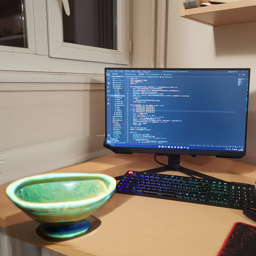

In [57]:
##############################
# Upsample the 64x64 samples #
##############################

tokens = model_up.tokenizer.encode(prompt)
tokens, mask = model_up.tokenizer.padded_tokens_and_mask(
    tokens, options_up['text_ctx']
)

# Create the model conditioning dict.
model_kwargs = dict(
    # Low-res image to upsample.
    low_res=((samples+1)*127.5).round()/127.5 - 1,

    # Text tokens
    tokens=th.tensor(
        [tokens] * batch_size, device=device
    ),
    mask=th.tensor(
        [mask] * batch_size,
        dtype=th.bool,
        device=device,
    ),

    # Masked inpainting image.
    inpaint_image=(source_image_256 * source_mask_256).repeat(batch_size, 1, 1, 1).to(device),
    inpaint_mask=source_mask_256.repeat(batch_size, 1, 1, 1).to(device),
)

def denoised_fn(x_start):
    # Force the model to have the exact right x_start predictions
    # for the part of the image which is known.
    return (
        x_start * (1 - model_kwargs['inpaint_mask'])
        + model_kwargs['inpaint_image'] * model_kwargs['inpaint_mask']
    )

# Sample from the base model.
model_up.del_cache()
up_shape = (batch_size, 3, options_up["image_size"], options_up["image_size"])
up_samples = diffusion_up.p_sample_loop(
    model_up,
    up_shape,
    noise=th.randn(up_shape, device=device) * upsample_temp,
    device=device,
    clip_denoised=True,
    progress=True,
    model_kwargs=model_kwargs,
    cond_fn=None,
    denoised_fn=denoised_fn,
)[:batch_size]
model_up.del_cache()

# Show the output
show_images(up_samples)

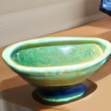

In [58]:
reversed_mask = (source_mask_256==0).to(int)
_, _, y_dim, x_dim = th.nonzero(reversed_mask, as_tuple=True)
xx1, xx2 = x_dim.min(), x_dim.max()
yy1, yy2 = y_dim.min(), y_dim.max()

generated_part = up_samples[:,:,yy1:yy2,xx1:xx2] 
show_images(generated_part)

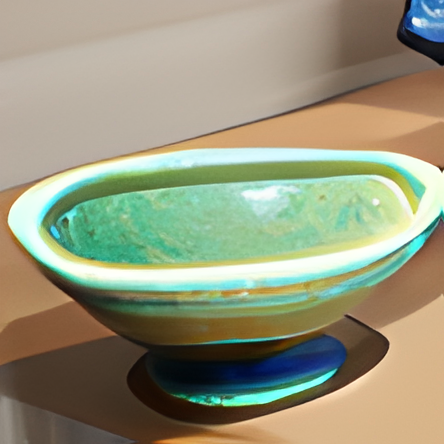

In [59]:
upscaled_img = upscaler.upscale(generated_part)
save_image(upscaled_img, f'{output_folder}/vase.png')
show_images(upscaled_img)